# Authorship Identification Project
#### Dov Greenwood, Shalaka Kulkarni, Keaton Mueller

In [1]:
%matplotlib inline
from collections import defaultdict
from random import shuffle
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models.ensemble_model import Ensemble
from models.compression_model import CompressionModel
from models.character_ngram_svm import CNGM
from models.word_frequency_model import BOW

from utils.data_reader import read_data

# Data Prep

In [2]:
from utils.data_reader import read_data
from random import shuffle
from math import ceil
from copy import deepcopy

def segment(string, chunk_size):
    '''
    Segments `string` into a list of strings of length `chunk_size`
    '''
    return [string[i:i + chunk_size] for i in range(0, len(string), chunk_size)]

STORED_DATA = read_data()

def prep_data(authors, test_pct=0, chunk_size=0):
    '''
    Prep data to be used in models.
    
    `authors` is a list of authors to prep data for.
    
    `test_pct` is a number between 0 and 1 indicating how much of the
    additional poetry per author should be designated as the test data.
    The Iliad will always be in the test data.
    
    `chunk_size` is an integer indicating how many characters to segment
    each piece into. 0 indicates no segmenting
    
    Returns a dict of the form:
    {
        'train': {
            author_name: [text, text, ...],
            author_name: [text, text, ...],
            ...
        }
        'test': [
            (text, author_name),
            (text, author_name),
            ...
        ]
    }
    ''' 
    # extract the authors of interest
    raw_data = { auth: deepcopy(texts) for auth, texts in STORED_DATA.items() if auth in authors }
        
    data = {
        'train': {},
        'test': []
    }
    
    
    # segment data if chunk_size > 0
    if chunk_size > 0:
        for auth in raw_data:
            raw_data[auth]['iliad'] = segment(raw_data[auth]['iliad'], chunk_size)
            raw_data[auth]['poetry'] = segment('\n'.join(raw_data[auth]['poetry']), chunk_size)
    
    # iliad always gets added to test data
    for auth in raw_data:
        iliad = raw_data[auth]['iliad']
        if type(iliad) == list:
            data['test'].extend([(text, auth) for text in iliad])
        elif type(iliad) == str:
            data['test'].append((iliad, auth))
    
    # split data into training and test
    for auth in raw_data:
        auth_data = raw_data[auth]['poetry']
        # shuffle so different texts are sorted into training and test (optional)
        shuffle(auth_data)
        
        idx = ceil(len(auth_data) * test_pct)
        test_set = auth_data[:idx]
        training_set = auth_data[idx:]
        
        data['train'][auth] = training_set
        data['test'].extend([(text, auth) for text in test_set])
        
    return data 

# Methods for Model Evaluation

In [3]:
def calculate_prf(matrix):
    '''
    Calculates precision, recall, and F1 score for the given
    confusion matrix. MUST be a simple 2x2 confusion matrix.
    
    Handles division by zero cases based on the following
    methodology: https://github.com/dice-group/gerbil/wiki/Precision,-Recall-and-F1-measure
    
    returns (precision, recall, F1 score) tuple
    '''
    if matrix['tp'] == 0:
        if matrix['fp'] == 0 and matrix['fn'] == 0:
            return 1.0, 1.0, 1.0
        if matrix['fp'] == 0 or matrix['fn'] == 0:
            return 0, 0, 0
    
    precision = matrix['tp'] / (matrix['tp'] + matrix['fp'])
    recall = matrix['tp'] / (matrix['tp'] + matrix['fn'])
    f1 = matrix['tp'] / (matrix['tp'] + 0.5 * (matrix['fp'] + matrix['fn']))
    
    return precision, recall, f1

def score_model(model, data):
    '''
    Function to test the model on the given data.
    
    `data` should be in the form of the output of 
    the `prep_data` function.
    
    return (micro_f1, macro_f1, confusion_matrix) tuple
    '''
    training_data = data['train']
    test_data = data['test']

    model.train(training_data)
    
    # confusion matrix to store results used for calculating precision and recall
    # confusion_matrix[gold_label][model_label] = number of occurrences
    confusion_matrix = defaultdict(lambda: defaultdict(lambda: 0))
    
    for text, gold_label in test_data:
        model_label = model.identify(text)[0][1]        
        confusion_matrix[gold_label][model_label] += 1
    
    # compute individual class matrices
    class_matrix = {}
    num_results = sum([sum(confusion_matrix[auth].values()) for auth in confusion_matrix])
    
    for auth in confusion_matrix:
        class_matrix[auth] = {
            'tp': confusion_matrix[auth][auth],
            'fp': sum([confusion_matrix[i][auth] for i in confusion_matrix if i != auth]),
            'fn': sum(confusion_matrix[auth].values()) - confusion_matrix[auth][auth]
        }
        class_matrix[auth]['tn'] = num_results - sum(class_matrix[auth].values())
        
    # compute a pooled matrix
    pooled_matrix = {
        'tp': sum([class_matrix[auth]['tp'] for auth in class_matrix]),
        'fp': sum([class_matrix[auth]['fp'] for auth in class_matrix]),
        'tn': sum([class_matrix[auth]['tn'] for auth in class_matrix]),
        'fn': sum([class_matrix[auth]['fn'] for auth in class_matrix])
    }
    
    # micro precision, recall, and F1
    micro_precision, micro_recall, micro_f1 = calculate_prf(pooled_matrix)

    # macro precision, recall, and F1
    class_precision = {}
    class_recall = {}
    
    for auth in class_matrix:
        p, r, _ = calculate_prf(class_matrix[auth])
        class_precision[auth] = p
        class_recall[auth] = r
    
    macro_precision = sum(class_precision.values()) / len(class_precision)
    macro_recall = sum(class_recall.values()) / len(class_recall)
    macro_f1 = (2 * macro_precision * macro_recall) / (macro_precision + macro_recall)
    
    # return F1 scores and confusion matrix
    return micro_f1, macro_f1, confusion_matrix

In [4]:
# NOTE: add Cowper once the data is done
authors = ['Pope', 'Dryden', 'Chapman']

def test_model(model):
    '''
    Thoroughly test the given model.
    
    Model is evaluated on different chunk sizes, different
    training/test data amounts, and with different
    groupings of authors.
    
    Return a dictionary containing all of the results
    '''
    results = {}
    
    # do tests on several different chunk sizes
    for chunk_size in [0, 20000]:
        # first perform a test on all authors
        results[f'{chunk_size}|all'] = score_model(model, prep_data(authors, chunk_size=chunk_size))

        if chunk_size > 0:
            # then do every pair-wise comparison if doing segmentation
            for i in range(len(authors)):
                for j in range(i + 1, len(authors)):
                    auth_1 = authors[i]
                    auth_2 = authors[j]
                    results[f'{chunk_size}|{auth_1} + {auth_2}'] = score_model(model, prep_data([auth_1, auth_2], chunk_size=chunk_size))
            
    return results

In [5]:
def k_fold_f1(model, train_data, folds=10):
    """
    Tests the given model by performing k-fold cross validation on the training data.
    
    model should be a model class, inherting AbstractModel.
    train_data should be the training data exactly as it should be prepared for the model classes.
    
    Returns the average Micro- and Macro-F1 score of the model as a numpy array.
    """
    train_data = {auth : '\n\n'.join(train_data[auth]) for auth in train_data}
    folded = {auth : [] for auth in train_data}
    for auth in train_data:
        lines = train_data[auth].split('\n')
        n_lines = len(lines)
        step = n_lines // folds
        for i in range(0, n_lines, step):
            folded[auth].append('\n'.join(lines[i : i+step]))
    
    aggregate = np.zeros((folds, 2))
    for i in range(folds):
        fold_train = {auth : (folded[auth][:i] + folded[auth][i+1:]) for auth in folded}
        fold_test = [(folded[auth][i], auth) for auth in folded]
        test_vals = score_model(model, {'train': fold_train, 'test': fold_test})
        aggregate[i] = [test_vals[0], test_vals[1]]
        ###print(aggregate[i])
    return np.mean(aggregate, axis=0)

# Evaluate Individual Models using `k_fold_f1`

In [6]:
with open('texts/Dryden/Dryden_train1.txt') as text: d = text.read()
with open('texts/Pope/Pope_train1.txt') as text: p = text.read()
with open('texts/Chapman/Chapman_train1.txt', encoding='UTF-8') as text: c = text.read()
with open('texts/Chapman/Chapman_train2.txt', encoding='UTF-8') as text: c += text.read()
with open('texts/Chapman/Chapman_train3.txt', encoding='UTF-8') as text: c += text.read()
with open('texts/Chapman/Chapman_train4.txt', encoding='UTF-8') as text: c += text.read()

In [7]:
cngm = CNGM(extended_alphabet=True)

In [8]:
cngm_eval = k_fold_f1(cngm, {'p':[p], 'c':[c], 'd':[d]}, folds=20)

In [9]:
cngm_eval

array([0.98333333, 0.97857143])

In [10]:
comp = CompressionModel()

In [11]:
comp_eval = k_fold_f1(comp, {'p':[p], 'c':[c], 'd':[d]}, folds=20)

In [12]:
comp_eval

array([0.83333333, 0.78690476])

In [13]:
bow = BOW()

In [14]:
bow_eval = k_fold_f1(bow, {'p':[p], 'c':[c], 'd':[d]}, folds=20)

In [15]:
bow_eval

array([0.91666667, 0.89404762])

# Calculate Weights, Initialize Ensemble Model

In [16]:
denom = cngm_eval[0] + comp_eval[0] + bow_eval[0]

In [17]:
wts = (bow_eval[0]/denom, comp_eval[0]/denom, cngm_eval[0]/denom)

In [18]:
wts

(0.3353658536585366, 0.3048780487804878, 0.3597560975609756)

In [19]:
ensm = Ensemble(weights=wts, CNGM_specs=(2, 0, True))

# Evaluate Ensemble Model on training data

In [20]:
ensm_eval = k_fold_f1(ensm, {'p':[p], 'c':[c], 'd':[d]}, folds=20)

In [21]:
ensm_eval

array([0.98333333, 0.97857143])

# Evaluate Models on Iliad test data

In [22]:
# note: takes about 5.5min
cngm_results = test_model(cngm)
comp_results = test_model(comp)
bow_results = test_model(bow)
ensm_results = test_model(ensm)

## Results on All Authors, No Segmentation

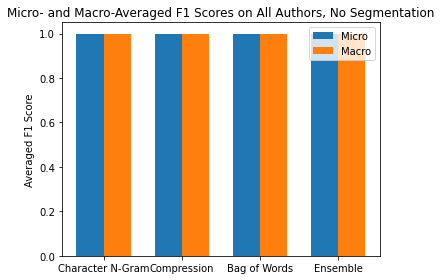

In [23]:
results = [cngm_results['0|all'], comp_results['0|all'], bow_results['0|all'], ensm_results['0|all']]

labels = ['Character N-Gram', 'Compression', 'Bag of Words', 'Ensemble']
micro_avgs = [res[0] for res in results]
macro_avgs = [res[1] for res in results]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, micro_avgs, width, label='Micro')
rects2 = ax.bar(x + width / 2, macro_avgs, width, label='Macro')

ax.set_ylabel('Averaged F1 Score')
ax.set_title('Micro- and Macro-Averaged F1 Scores on All Authors, No Segmentation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

try:
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
except AttributeError:
    # this feature requires matplotlib 3.4
    pass

fig.tight_layout()

plt.show()

## Results on All Authors, Segmented into 20k Character Chunks

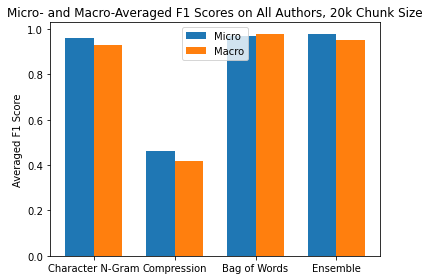

In [24]:
results = [cngm_results['20000|all'], comp_results['20000|all'], bow_results['20000|all'], ensm_results['20000|all']]

labels = ['Character N-Gram', 'Compression', 'Bag of Words', 'Ensemble']
micro_avgs = [round(res[0], 2) for res in results]
macro_avgs = [round(res[1], 2) for res in results]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, micro_avgs, width, label='Micro')
rects2 = ax.bar(x + width / 2, macro_avgs, width, label='Macro')

ax.set_ylabel('Averaged F1 Score')
ax.set_title('Micro- and Macro-Averaged F1 Scores on All Authors, 20k Chunk Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

try:
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
except AttributeError:
    # this feature requires matplotlib 3.4
    pass

fig.tight_layout()

plt.show()

## Results on Pope and Dryden, Segmented into 20k Character Chunks

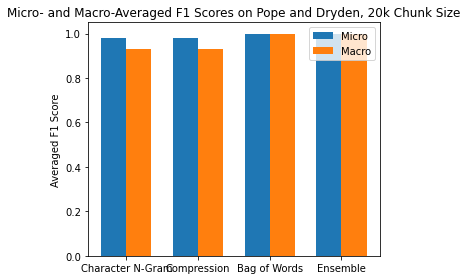

In [25]:
results_all = [cngm_results['20000|Pope + Dryden'], comp_results['20000|Pope + Dryden'], bow_results['20000|Pope + Dryden'], ensm_results['20000|Pope + Dryden']]

labels = ['Character N-Gram', 'Compression', 'Bag of Words', 'Ensemble']
micro_avgs = [round(res[0], 2) for res in results_all]
macro_avgs = [round(res[1], 2) for res in results_all]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, micro_avgs, width, label='Micro')
rects2 = ax.bar(x + width / 2, macro_avgs, width, label='Macro')

ax.set_ylabel('Averaged F1 Score')
ax.set_title('Micro- and Macro-Averaged F1 Scores on Pope and Dryden, 20k Chunk Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

try:
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
except AttributeError:
    # this feature requires matplotlib 3.4
    pass

fig.tight_layout()

plt.show()

## Results on Pope and Chapman, Segmented into 20k Character Chunks

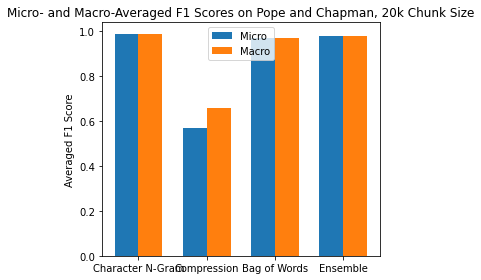

In [26]:
results_all = [cngm_results['20000|Pope + Chapman'], comp_results['20000|Pope + Chapman'], bow_results['20000|Pope + Chapman'], ensm_results['20000|Pope + Chapman']]

labels = ['Character N-Gram', 'Compression', 'Bag of Words', 'Ensemble']
micro_avgs = [round(res[0], 2) for res in results_all]
macro_avgs = [round(res[1], 2) for res in results_all]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, micro_avgs, width, label='Micro')
rects2 = ax.bar(x + width / 2, macro_avgs, width, label='Macro')

ax.set_ylabel('Averaged F1 Score')
ax.set_title('Micro- and Macro-Averaged F1 Scores on Pope and Chapman, 20k Chunk Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

try:
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
except AttributeError:
    # this feature requires matplotlib 3.4
    pass

fig.tight_layout()

plt.show()

## Results on Dryden and Chapman, Segmented into 20k Character Chunks

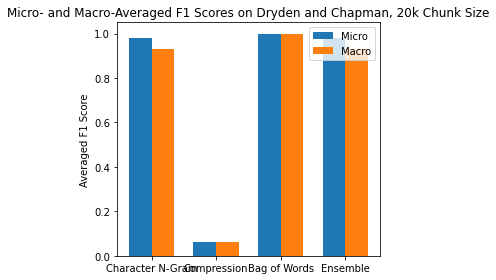

In [27]:
results_all = [cngm_results['20000|Dryden + Chapman'], comp_results['20000|Dryden + Chapman'], bow_results['20000|Dryden + Chapman'], ensm_results['20000|Dryden + Chapman']]

labels = ['Character N-Gram', 'Compression', 'Bag of Words', 'Ensemble']
micro_avgs = [round(res[0], 2) for res in results_all]
macro_avgs = [round(res[1], 2) for res in results_all]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, micro_avgs, width, label='Micro')
rects2 = ax.bar(x + width / 2, macro_avgs, width, label='Macro')

ax.set_ylabel('Averaged F1 Score')
ax.set_title('Micro- and Macro-Averaged F1 Scores on Dryden and Chapman, 20k Chunk Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

try:
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
except AttributeError:
    # this feature requires matplotlib 3.4
    pass

fig.tight_layout()

plt.show()

# Test Identification of Dryden versus Homer

In [29]:
with open('texts/Dryden/Dryden_iliad_1_p6.txt') as text: d_iliad = text.read()
with open('texts/Pope/Pope_iliad.txt', encoding='UTF-8') as text: p_iliad = text.read()
with open('texts/Chapman/Chapman_iliad.txt', encoding='UTF-8') as text: c_iliad = text.read()

In [30]:
ensm2 = Ensemble(weights=wts, CNGM_specs=(2, 0, True))

In [31]:
ensm2.train({'Dryden':[d], 'Homer':[p_iliad, c_iliad]})

In [32]:
ensm2.identify(d_iliad)

[(0.565028795707692, 'Homer'), (0.434971204292308, 'Dryden')]

# Test Identification of Pope versus Homer

In [33]:
ensm2.train({'Pope':[p], 'Homer':[d_iliad, c_iliad]})

In [34]:
ensm2.identify(p_iliad)

[(0.6302390501773056, 'Pope'), (0.3697609498226945, 'Homer')]

# Test Identification of Chapman versus Homer

In [35]:
ensm2.train({'Chapman':[c], 'Homer':[d_iliad, p_iliad]})

In [36]:
ensm2.identify(c_iliad)

[(0.6589337780097444, 'Homer'), (0.3410662219902555, 'Chapman')]